In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [2]:
DEFORMATION_METHODS = ["Random", "Mirror"]
OPTIMIZER_METHODS = ["Iterative", "Annealing"]

In [3]:
def graph_json_iterative(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        sampling_rate = json_data['SamplingRate']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]
        optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
        accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        iterations = chosen_vertices.size
        deviations = np.array(json_data['Deviations'], dtype='float').reshape((iterations, offsets.size))
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
        time_ms = json_data['TimeMilliseconds']

        min_deviation = np.min(deviations[-1])
        max_deviation = np.max(deviations)
        min_offset = np.round(np.min(offsets), 2)
        max_offset = np.round(np.max(offsets), 2)
        effective_iterations = np.sum(accepted_iterations)

        deviation_diff_percent = (min_deviation-deformed_deviation)/deformed_deviation * 100

        xplots = 10
        yplots = math.ceil(iterations/xplots)
        # Limit the amount of y plots into a nice square
        yplots = min(yplots, xplots)
        figsize_multiplier = 4
        fig, axs = plt.subplots(yplots, xplots, figsize=(xplots*figsize_multiplier, yplots*figsize_multiplier))

        info = f"Plot of total angular deviation (0; {np.round(max_deviation,2)}) per offset ({min_offset}; {max_offset}), sampled every {sampling_rate}\n"
        info += f"Object: {name}\n"
        info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)\n"
        info += f"Deformation method: {deformation_method}"
        info += f"Optimizer method: {optimizer_method}\n"
        info += f"Vertex selection method: {vertex_selection_method}\n"
        if (deformation_method == "Random" or vertex_selection_method == "Random"):
            info += f" (seed {seed})\n"
        info += f"First {min(xplots*yplots, iterations)}/{iterations} iterations plotted ltr-ttb\n"
        info += f"{effective_iterations} iterations of total amount ({np.round(effective_iterations/iterations*100, 2)}%) reduced the minimum\n"
        info += f"Time: {time_ms} ms\n"
        info += f"Total angular deviation reduced from {np.round(deformed_deviation, 2)} to {np.round(min_deviation, 2)} ({np.round(deviation_diff_percent, 2)}%)\n"
        info += f"\nLEGEND\n"
        info += f"-------------\n"
        info += f"v: Current iteration's vertex\n"
        info += f"ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint\n"
        info += f"cd: Current deviation\n"
        info += f"md: Minimum deviation of iteration\n"
        info += f"off: offset that corresponds to the (discrete) minimum\n"
        info += f"\nblue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)\n"
        info += f"pink: quadratic approximation of the original data\n"
        info += f"black dashed: current total angular deviation\n"
        print(info)

        for y in range(yplots):
            for x in range(xplots):
                iter = y*xplots + x
                if iter < iterations:
                    # Plot the discrete data
                    color = 'blue' if accepted_iterations[iter] else 'red'
                    axs[y,x].plot(offsets, deviations[iter], c=color)

                    # Plot the deviation it should be lower than
                    axs[y,x].axhline(y=current_deviations[iter], color='black', linestyle="--", linewidth=0.5)

                    # Plot the quadratically fitted approximation of the data
                    min_dev_offset_index = np.argmin(deviations[iter])

                    model = np.poly1d(np.polyfit(offsets, deviations[iter], 2))
                    model_deviations = model(offsets)
                    model_min_dev_index = np.argmin(model_deviations)
                    axs[y,x].plot(offsets, model_deviations, color='magenta')

                    # Make the title
                    vertex = chosen_vertices[iter]
                    title = f"v: {vertex}"
                    title += f"\nndfr: {np.round(ideal_normal_angles_from_ray[vertex],1)}"
                    title += f"\ncd: {np.round(current_deviations[iter], 3)}"
                    title += f"\noff: {np.round(offsets[min_dev_offset_index], 3)}"
                    title += f"\nmd: {np.round(deviations[iter, min_dev_offset_index], 3)}"
                    title += f"\naoff: {np.round(offsets[model_min_dev_index], 3)}"
                    title += f"\namd: {np.round(model_deviations[model_min_dev_index], 3)}"
                    axs[y,x].set_title(title)

                # Set the axes invisible
                # axs[y,x].set_ylim(0, max_deviation)
                axs[y,x].set_xticklabels([])
                axs[y,x].set_yticklabels([])
        
        fig.tight_layout()
        fig.show()

In [4]:
def graph_offset_histogram_iterative(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        sampling_rate = json_data['SamplingRate']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]
        optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
        accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        iterations = chosen_vertices.size
        deviations = np.array(json_data['Deviations'], dtype='float').reshape((iterations, offsets.size))
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
        time_ms = json_data['TimeMilliseconds']

        applied_offsets = []
        # Gather all offsets of iterations that reduced the minimum
        for iter in range(iterations):
            if not accepted_iterations[iter]:
                continue
            min_dev_index = np.argmin(deviations[iter])
            min_offset = offsets[min_dev_index]
            applied_offsets.append(min_offset)
        
        fig = plt.figure()
        plt.hist(applied_offsets)
        fig.show()

In [5]:
def graph_json_annealing(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        name = json_data['ObjectName']
        seed = json_data['Seed']
        vertex_count = json_data['VertexCount']
        sampling_rate = json_data['SamplingRate']
        deformed_deviation = json_data['DeformedAngularDeviation']
        deformation_method = DEFORMATION_METHODS[json_data['DeformationMethod']]
        optimizer_method = OPTIMIZER_METHODS[json_data['OptimizerMethod']]
        vertex_selection_method = json_data['VertexSelectionMethod']
        offsets = np.array(json_data['Offsets'], dtype='float')
        chosen_vertices = np.array(json_data['ChosenVertices'], dtype='int')
        accepted_iterations = np.array(json_data['AcceptedIterations'], dtype='bool')
        ideal_normal_angles_from_ray = np.array(json_data['IdealNormalAnglesFromRay'], dtype='float')
        iterations = chosen_vertices.size
        deviations = np.array(json_data['Deviations'], dtype='float')
        current_deviations = np.array(json_data['CurrentDeviations'], dtype=float)
        time_ms = json_data['TimeMilliseconds']

        final_deviation = deviations[-1]
        deviation_diff_percent = (final_deviation - deviations[0]) / deviations[0] * 100
        effective_iterations = np.sum(accepted_iterations)

        temps = [1 - i / (iterations-1) for i in range(iterations)]

        info = f"Plot of total angular deviation for {iterations} iterations\n"
        info += f"Object: {name}\n"
        info += f"Vertices: {vertex_count} (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)\n"
        info += f"Deformation method: {deformation_method}\n"
        info += f"Optimizer method: {optimizer_method}\n"
        info += f"Vertex selection method: {vertex_selection_method}\n"
        if (deformation_method == "Random" or vertex_selection_method == "Random"):
            info += f" (seed {seed})\n"
        info += f"{effective_iterations} iterations of total amount ({np.round(effective_iterations/iterations*100, 2)}%) reduced the minimum\n"
        info += f"Time: {time_ms} ms\n"
        info += f"Total angular deviation reduced from {np.round(deformed_deviation, 2)} to {np.round(final_deviation, 2)} ({np.round(deviation_diff_percent, 2)}%)\n"
        info += f"\nLEGEND\n"
        info += f"-------------\n"
        info += f"v: Current iteration's vertex\n"
        info += f"ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint\n"
        info += f"cd: Current deviation\n"
        info += f"md: Minimum deviation of iteration\n"
        info += f"off: offset that corresponds to the (discrete) minimum\n"
        info += f"\nblue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)\n"
        info += f"pink: quadratic approximation of the original data\n"
        info += f"black dashed: current total angular deviation\n"
        print(info)

        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs[0].plot(range(iterations), current_deviations)
        ax2=axs[0].twinx()
        ax2.plot(range(iterations), temps, color='red')

        axs[1].hist(offsets)
            
        fig.tight_layout()
        fig.show()

Plot of total angular deviation (0; 1360.85) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Tetrahedron
Vertices: 12 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 26/26 iterations plotted ltr-ttb
5 iterations of total amount (19.23%) reduced the minimum
Time: 1330 ms
Total angular deviation reduced from 229.31 to 110.78 (-51.69%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


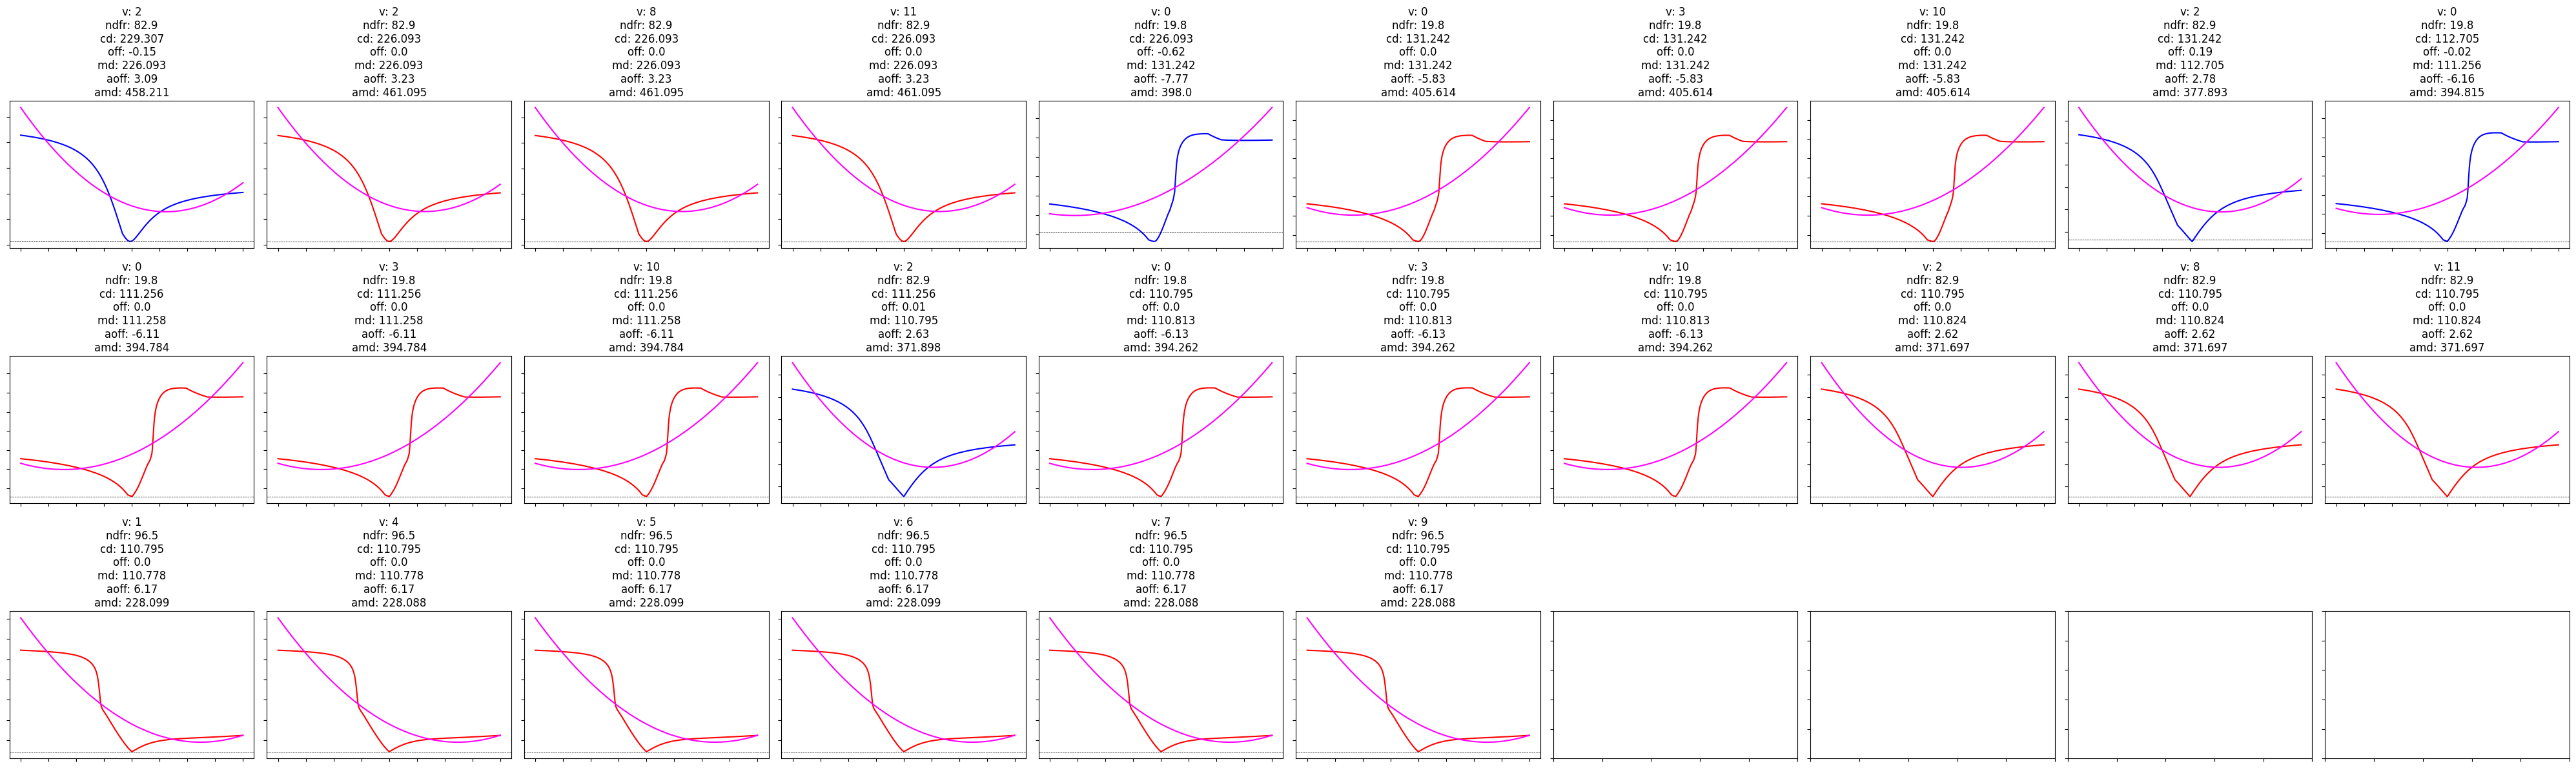

In [6]:
graph_json_iterative("Tetrahedron_Mirror_26-Iterative_at_0.010_in_-10.00_to_9.99.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


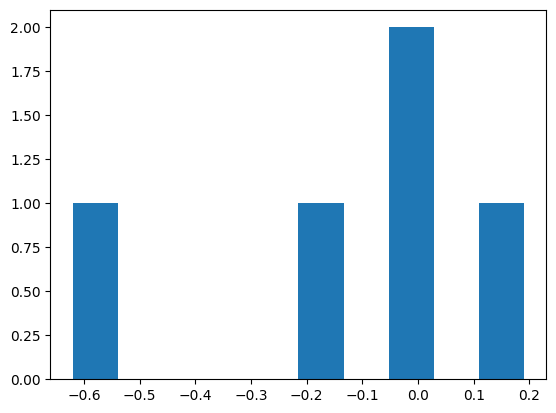

In [7]:
graph_offset_histogram_iterative("Tetrahedron_Mirror_26-Iterative_at_0.010_in_-10.00_to_9.99.json")

Plot of total angular deviation (0; 524.07) per offset (-1.0; 1.0), sampled every 0.009999999776482582
Object: Tetrahedron
Vertices: 12 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 26/26 iterations plotted ltr-ttb
5 iterations of total amount (19.23%) reduced the minimum
Time: 498 ms
Total angular deviation reduced from 229.31 to 110.71 (-51.72%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (bl

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


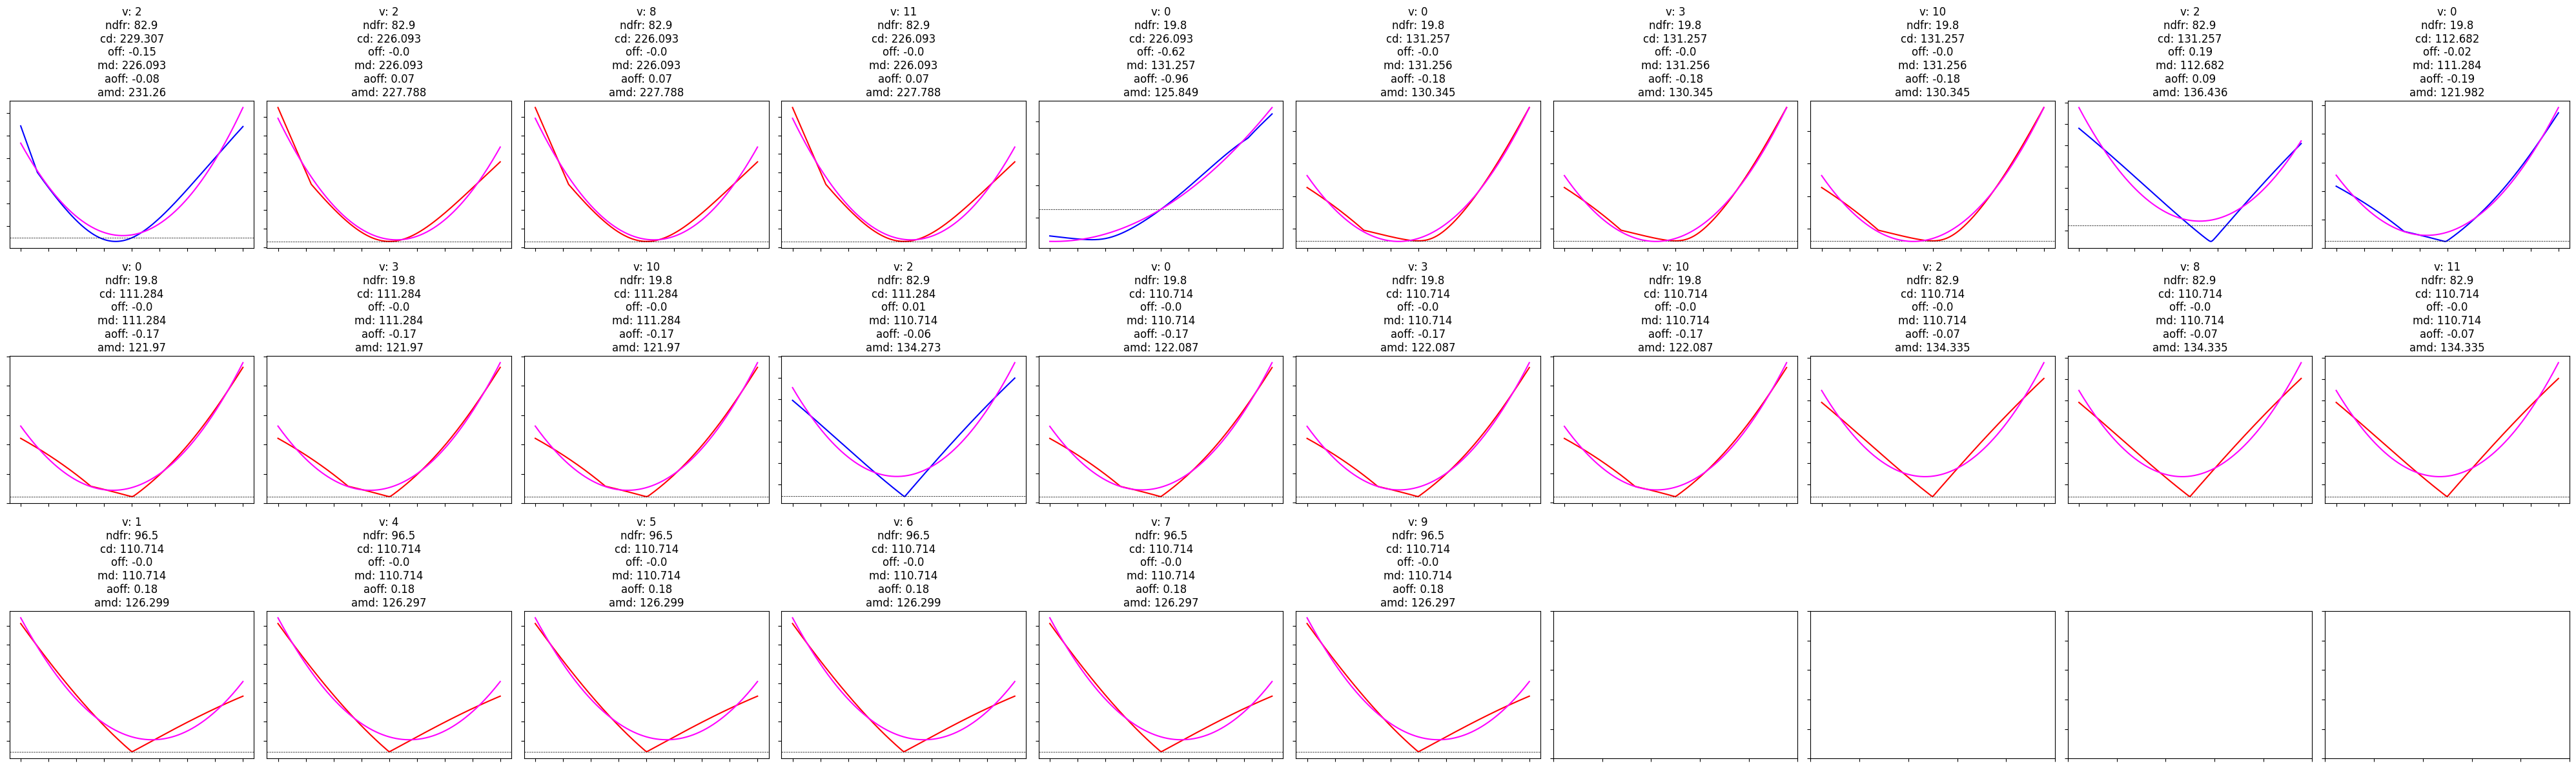

In [8]:
graph_json_iterative("Tetrahedron_Mirror_26-Iterative_at_0.010_in_-1.00_to_1.00.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


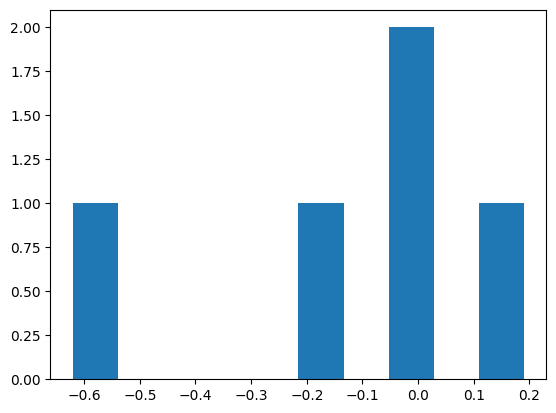

In [9]:
graph_offset_histogram_iterative("Tetrahedron_Mirror_26-Iterative_at_0.010_in_-1.00_to_1.00.json")

Plot of total angular deviation (0; 1302.97) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Cube
Vertices: 24 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/1000 iterations plotted ltr-ttb
189 iterations of total amount (18.9%) reduced the minimum
Time: 107985 ms
Total angular deviation reduced from 107.27 to 32.91 (-69.32%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


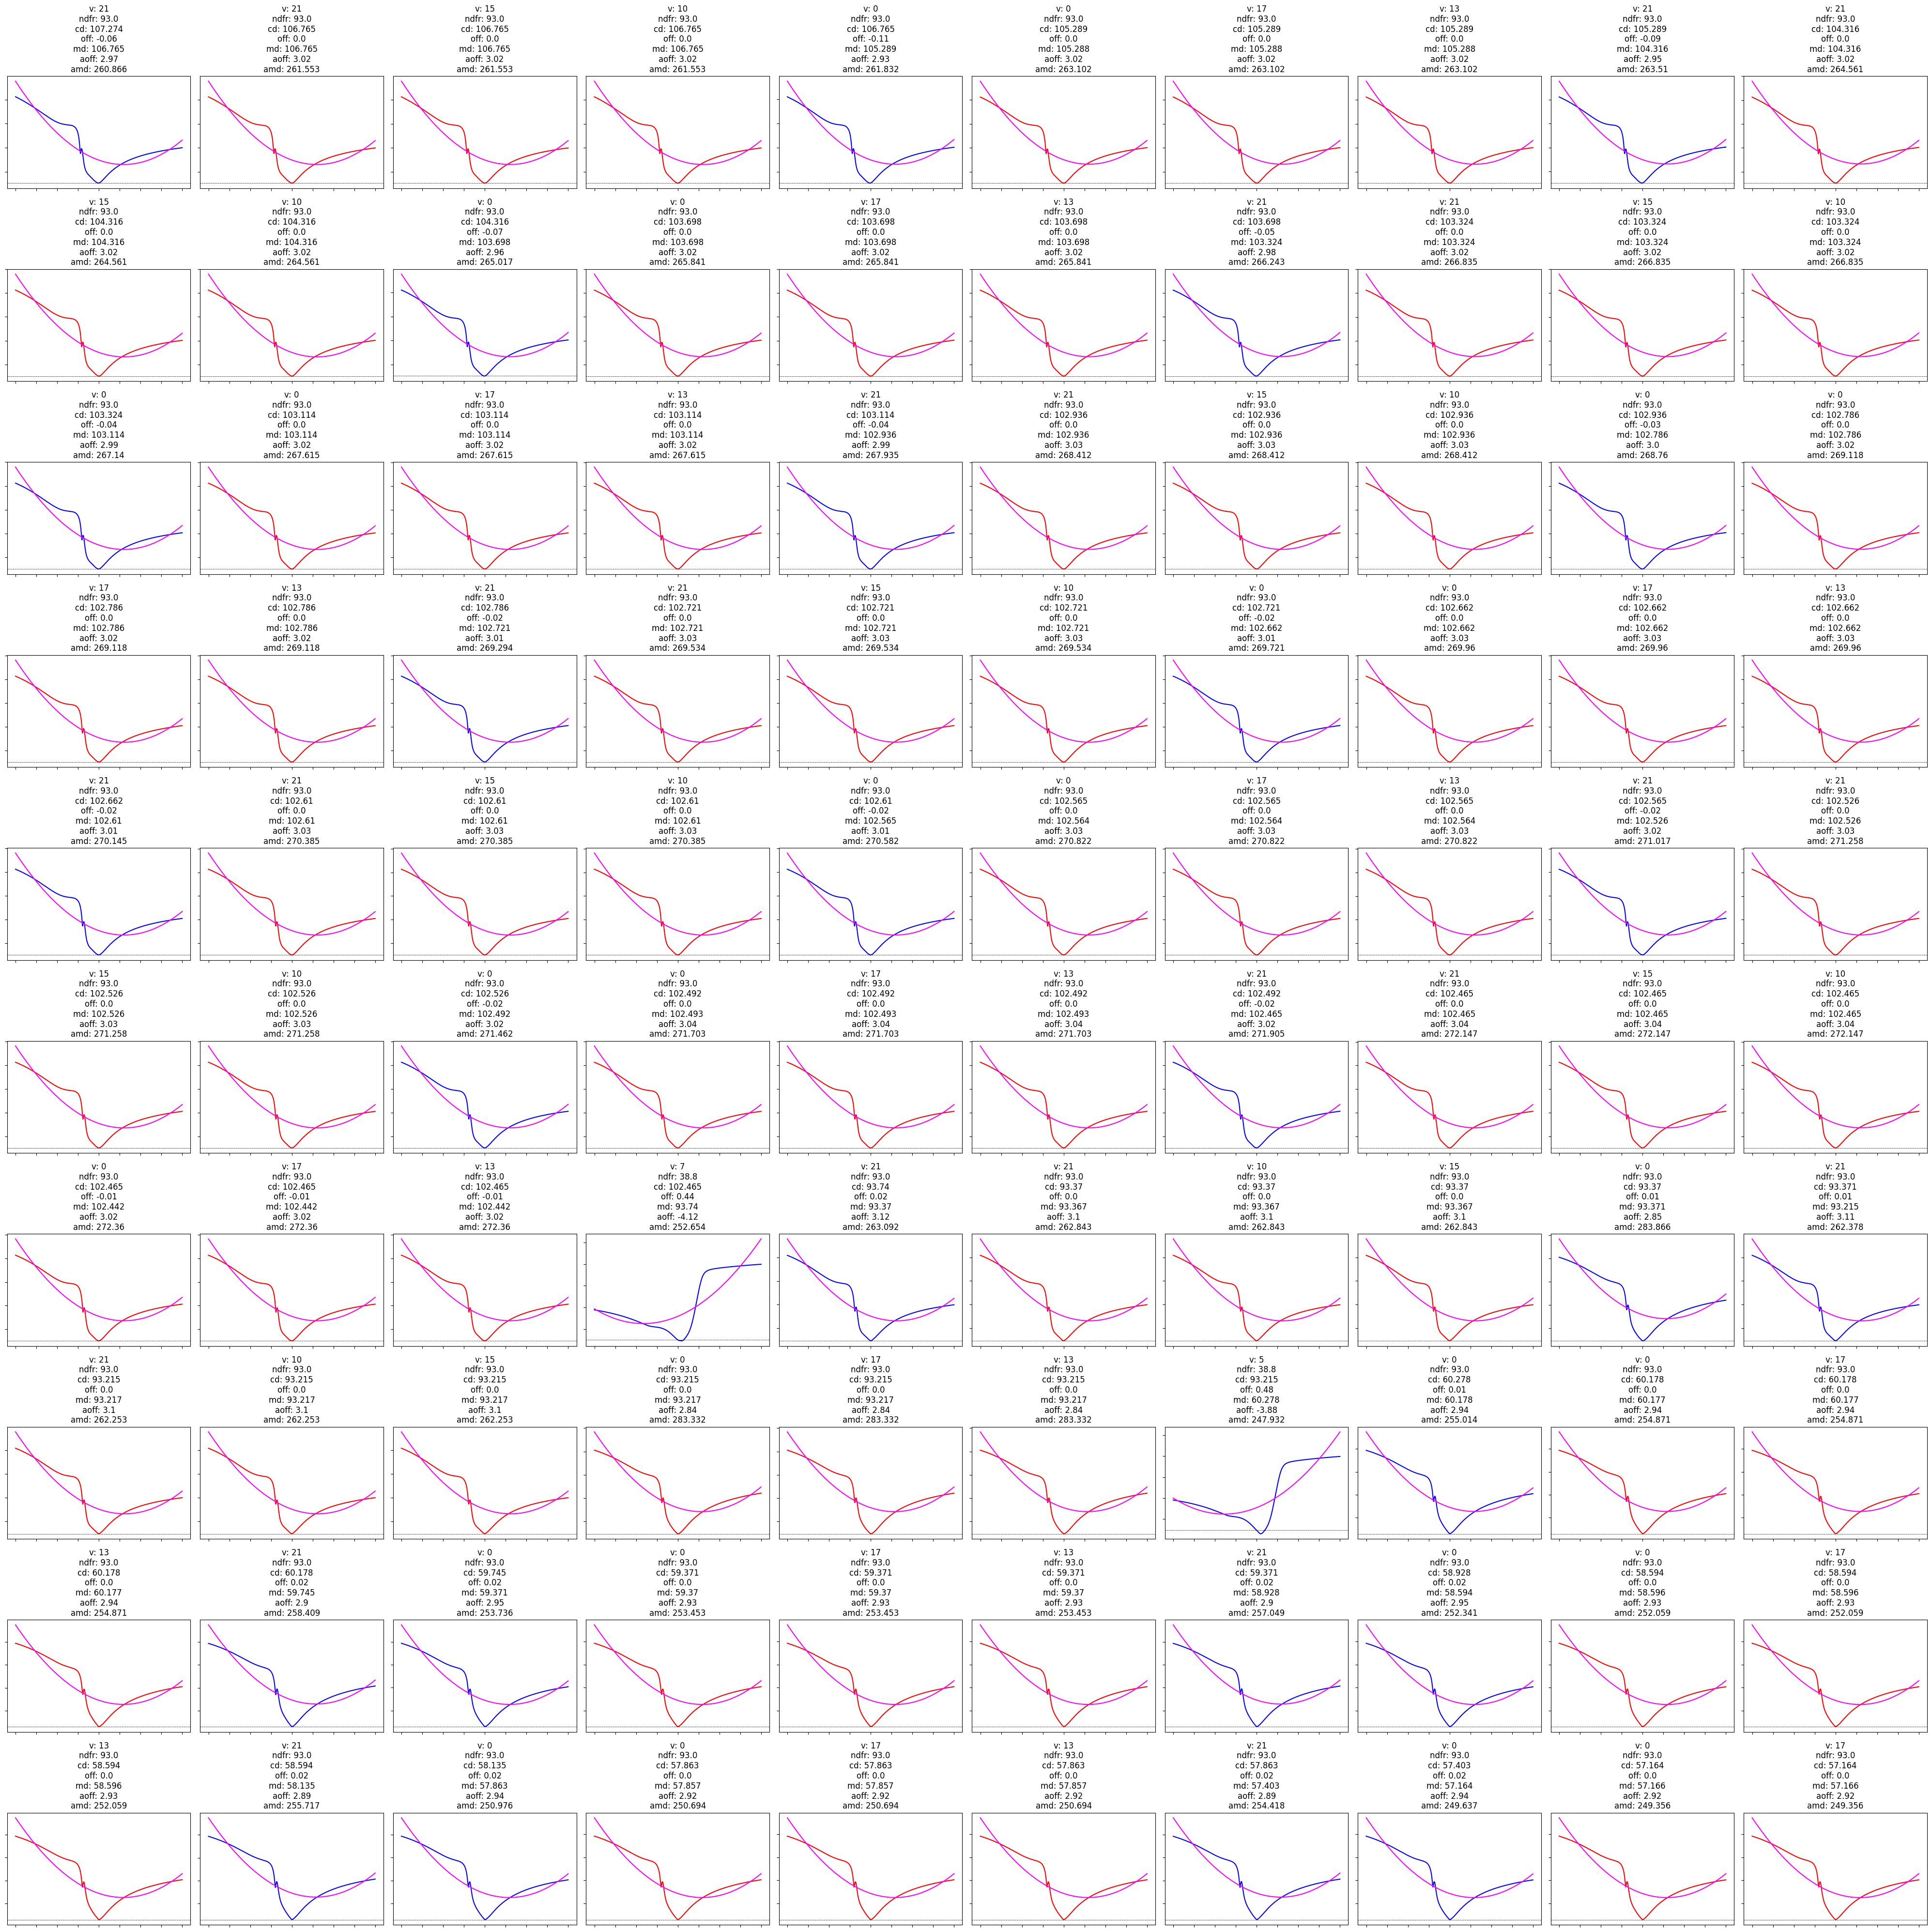

In [10]:
graph_json_iterative("Cube_Mirror_1000-Iterative_at_0.010_in_-10.00_to_9.99.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


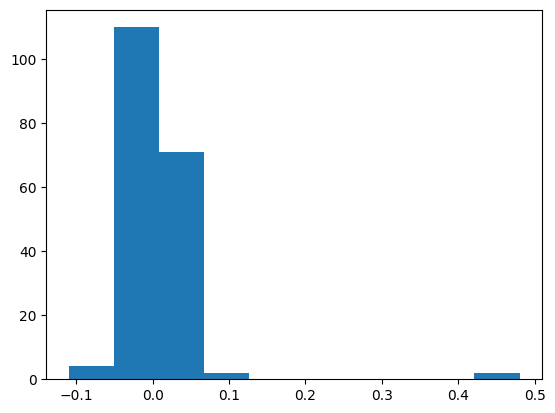

In [11]:
graph_offset_histogram_iterative("Cube_Mirror_1000-Iterative_at_0.010_in_-10.00_to_9.99.json")

Plot of total angular deviation (0; 218.83) per offset (-1.0; 1.0), sampled every 0.009999999776482582
Object: Cube
Vertices: 24 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/1000 iterations plotted ltr-ttb
229 iterations of total amount (22.9%) reduced the minimum
Time: 25965 ms
Total angular deviation reduced from 107.27 to 36.26 (-66.19%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


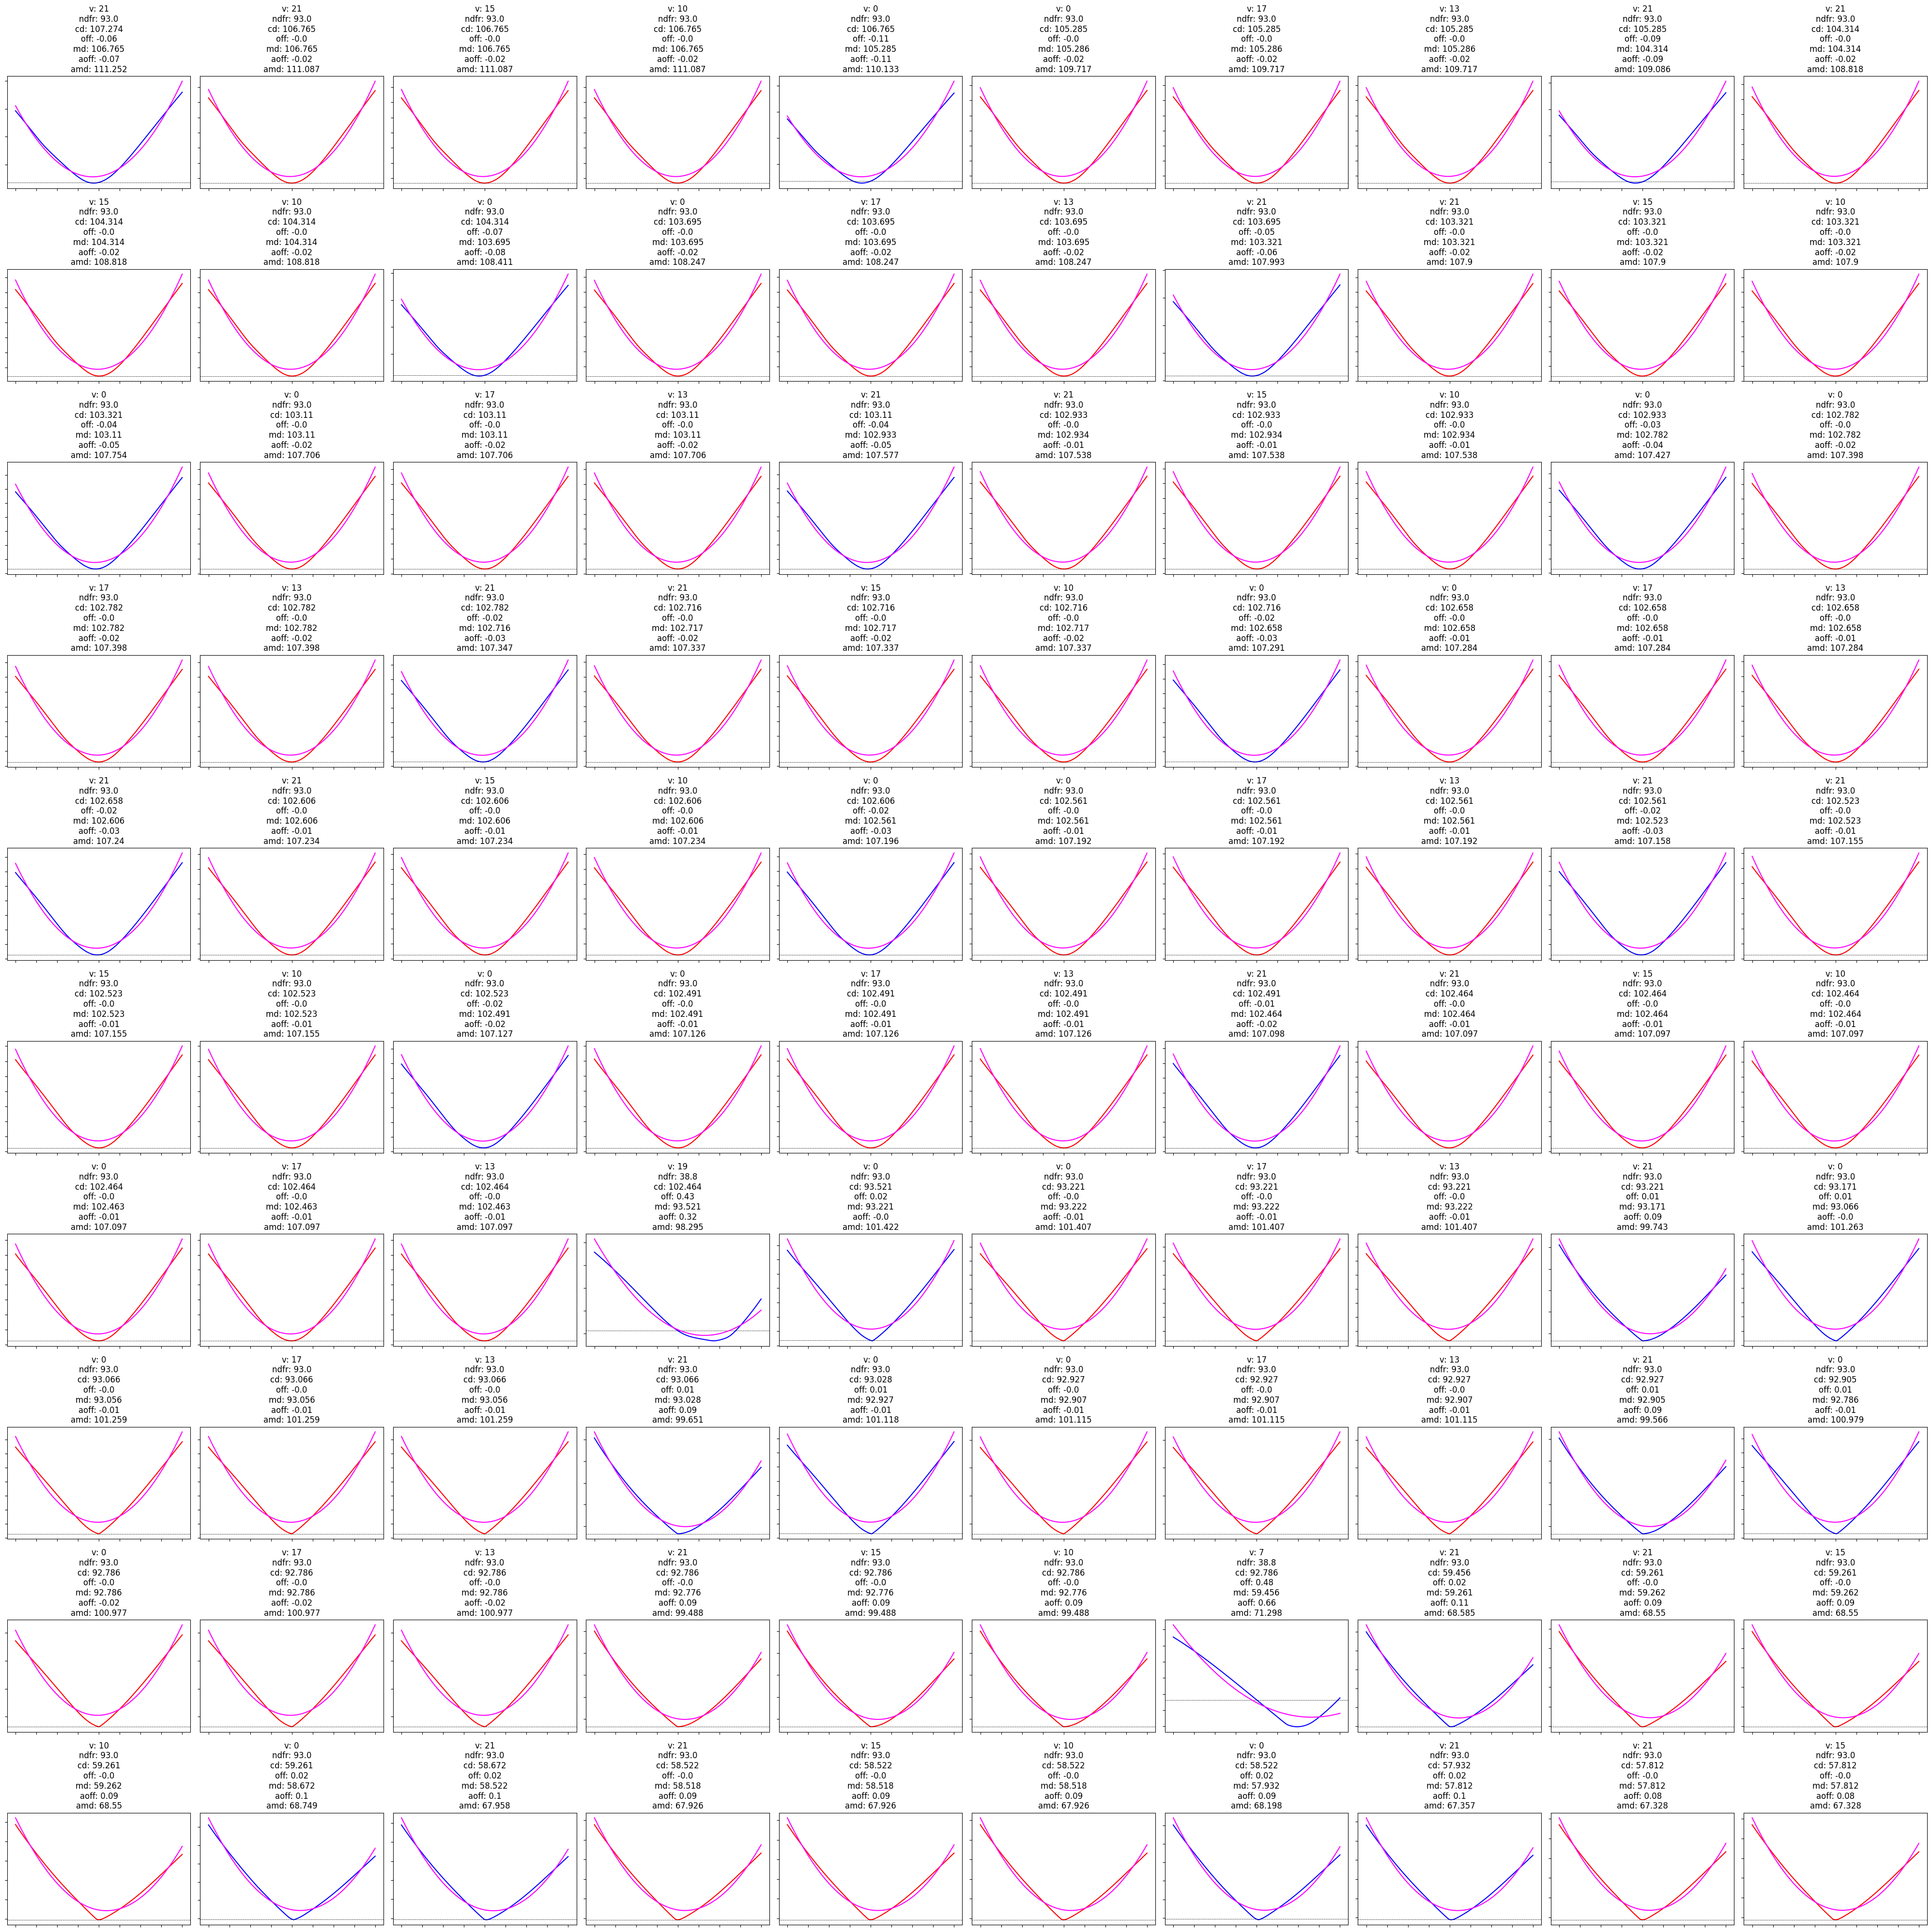

In [12]:
graph_json_iterative("Cube_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


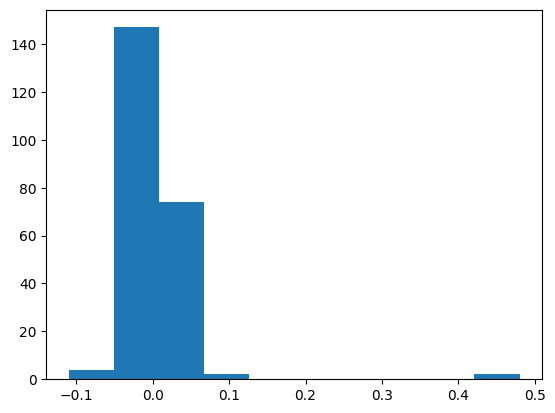

In [13]:
graph_offset_histogram_iterative("Cube_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

Plot of total angular deviation (0; 1489.04) per offset (-10.0; 9.99), sampled every 0.009999999776482582
Object: Icosahedron
Vertices: 60 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/1000 iterations plotted ltr-ttb
81 iterations of total amount (8.1%) reduced the minimum
Time: 197185 ms
Total angular deviation reduced from 512.02 to 373.29 (-27.1%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the mini

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


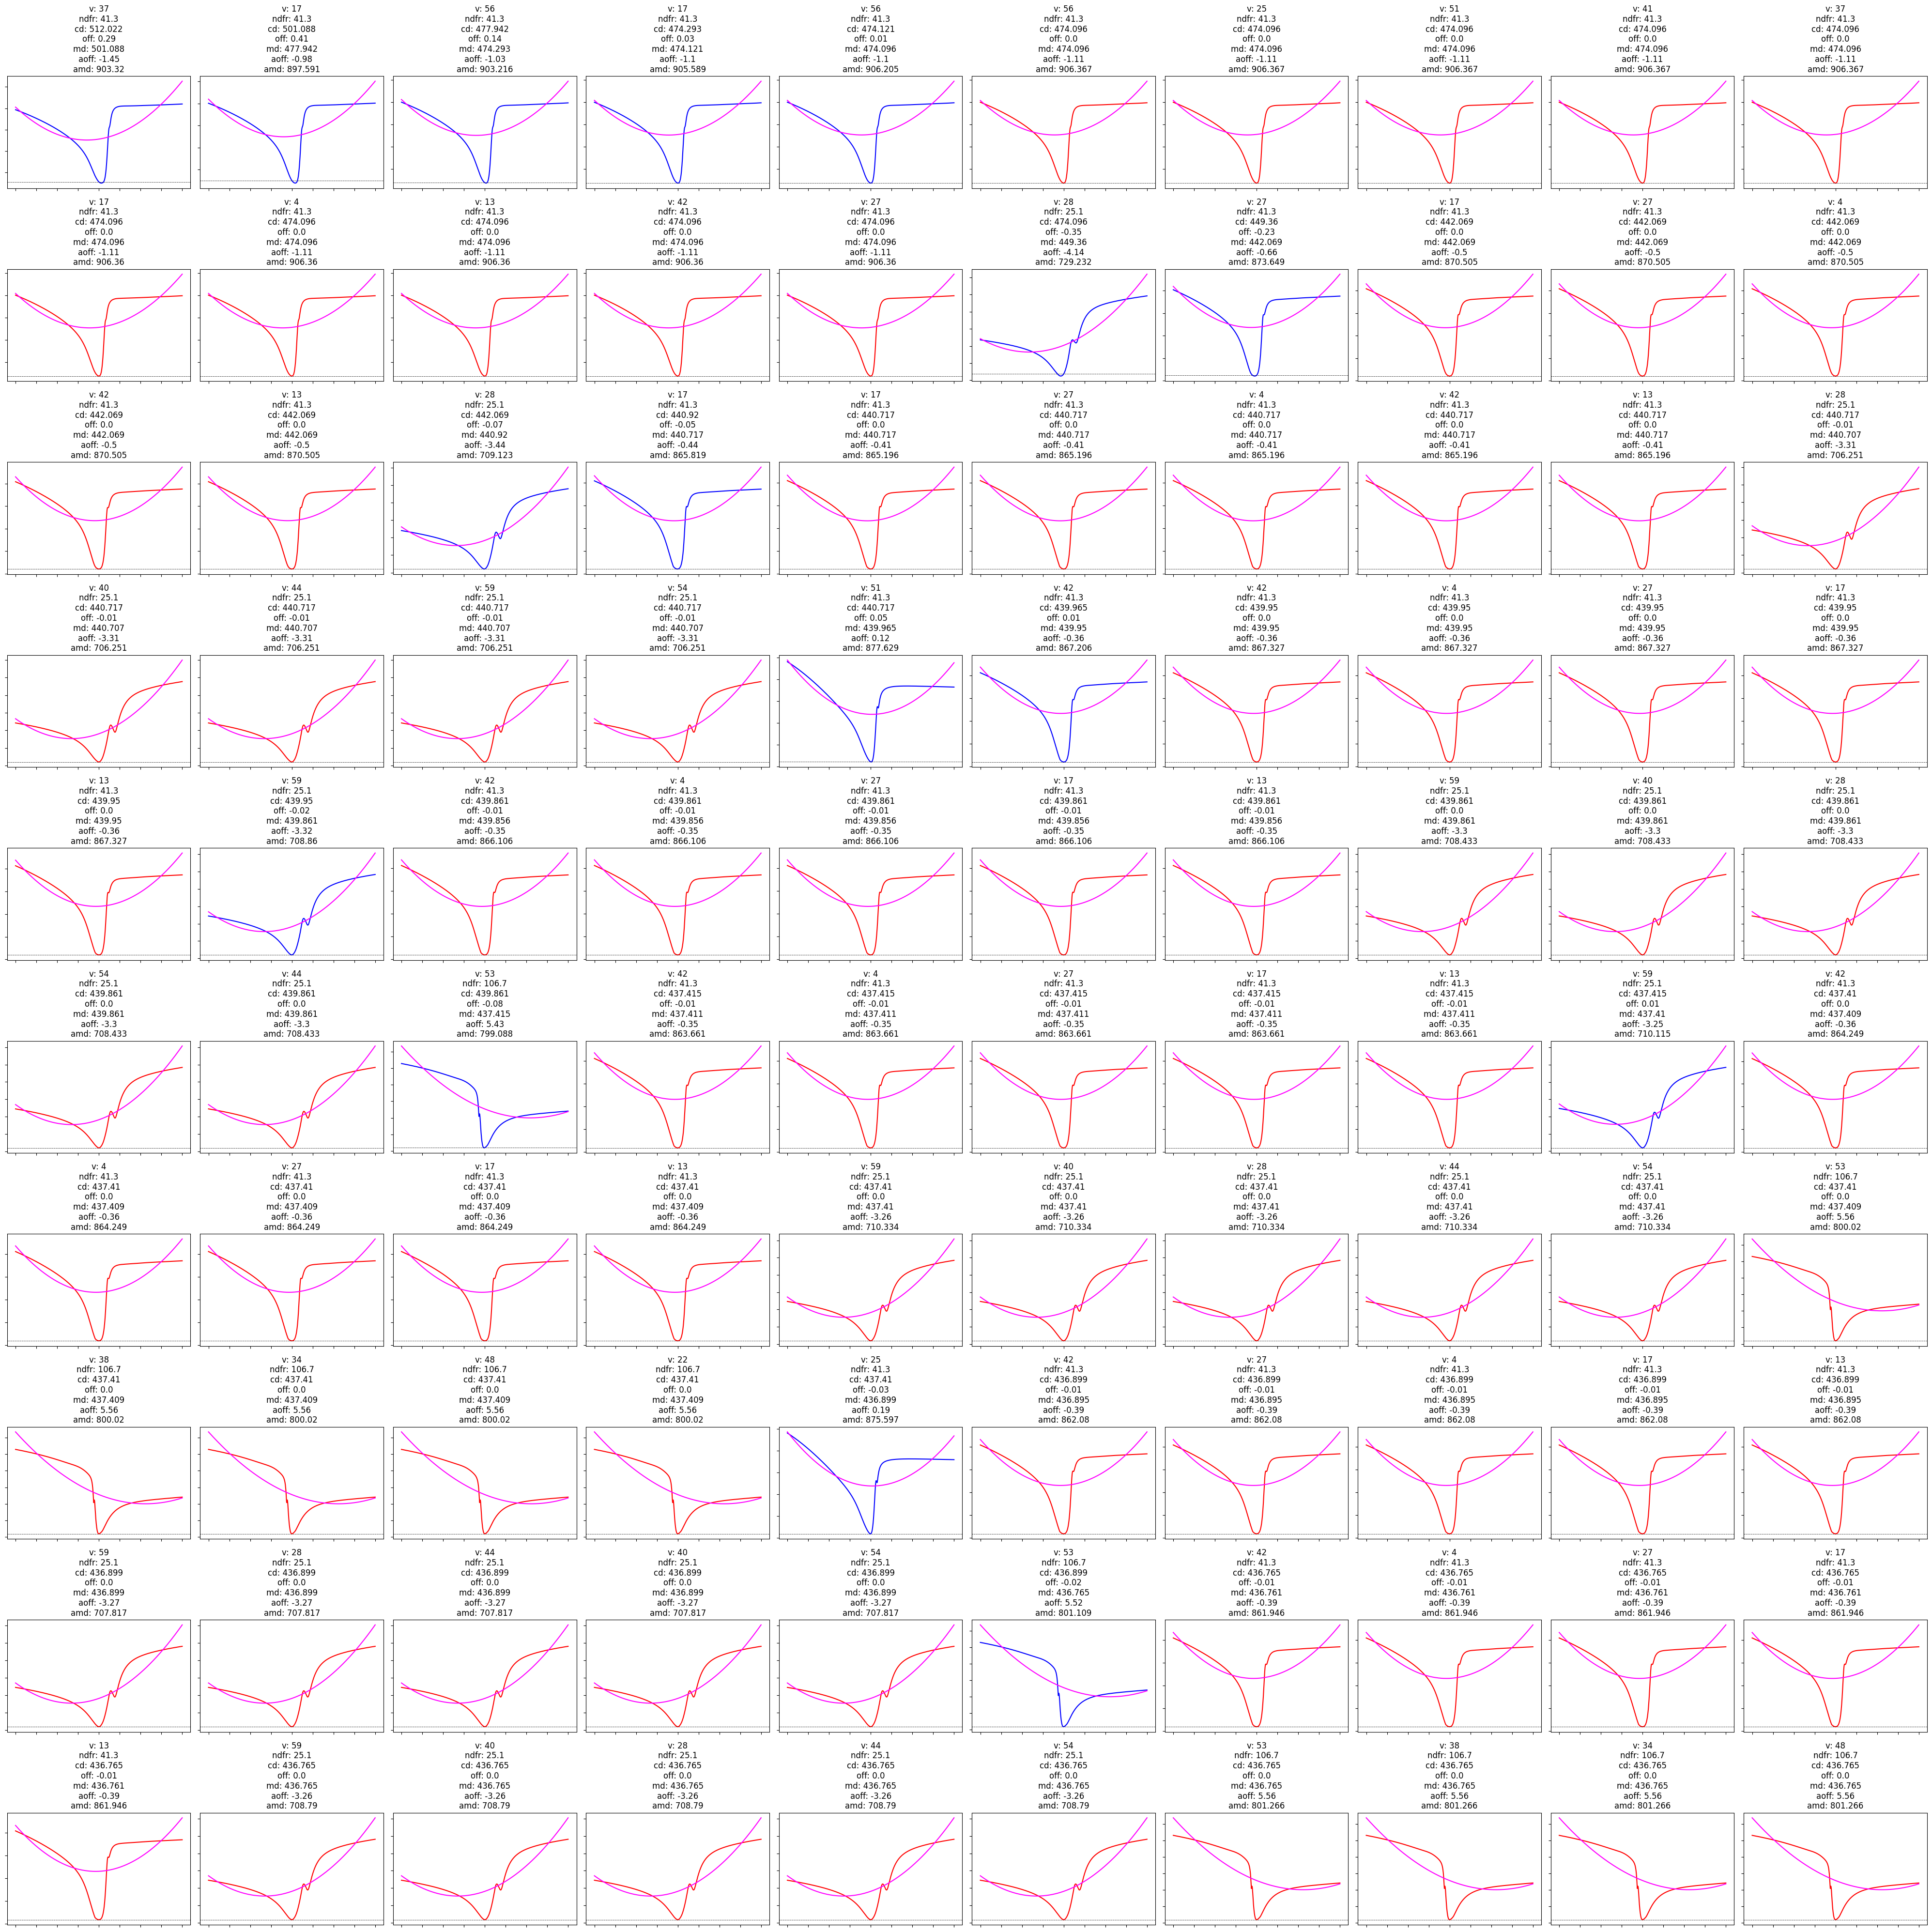

In [14]:
graph_json_iterative("Icosahedron_Mirror_1000-Iterative_at_0.010_in_-10.00_to_9.99.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


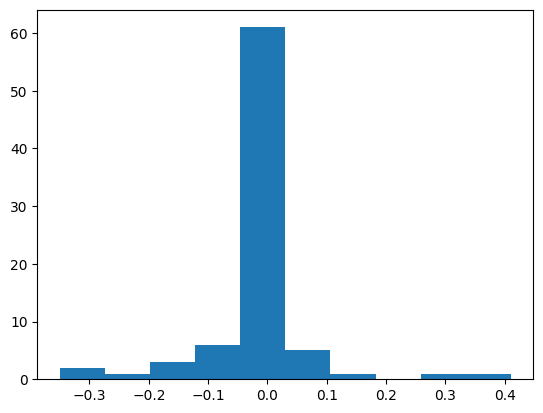

In [15]:
graph_offset_histogram_iterative("Icosahedron_Mirror_1000-Iterative_at_0.010_in_-10.00_to_9.99.json")

Plot of total angular deviation (0; 1125.2) per offset (-1.0; 1.0), sampled every 0.009999999776482582
Object: Icosahedron
Vertices: 60 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/1000 iterations plotted ltr-ttb
84 iterations of total amount (8.4%) reduced the minimum
Time: 38468 ms
Total angular deviation reduced from 512.02 to 413.91 (-19.16%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


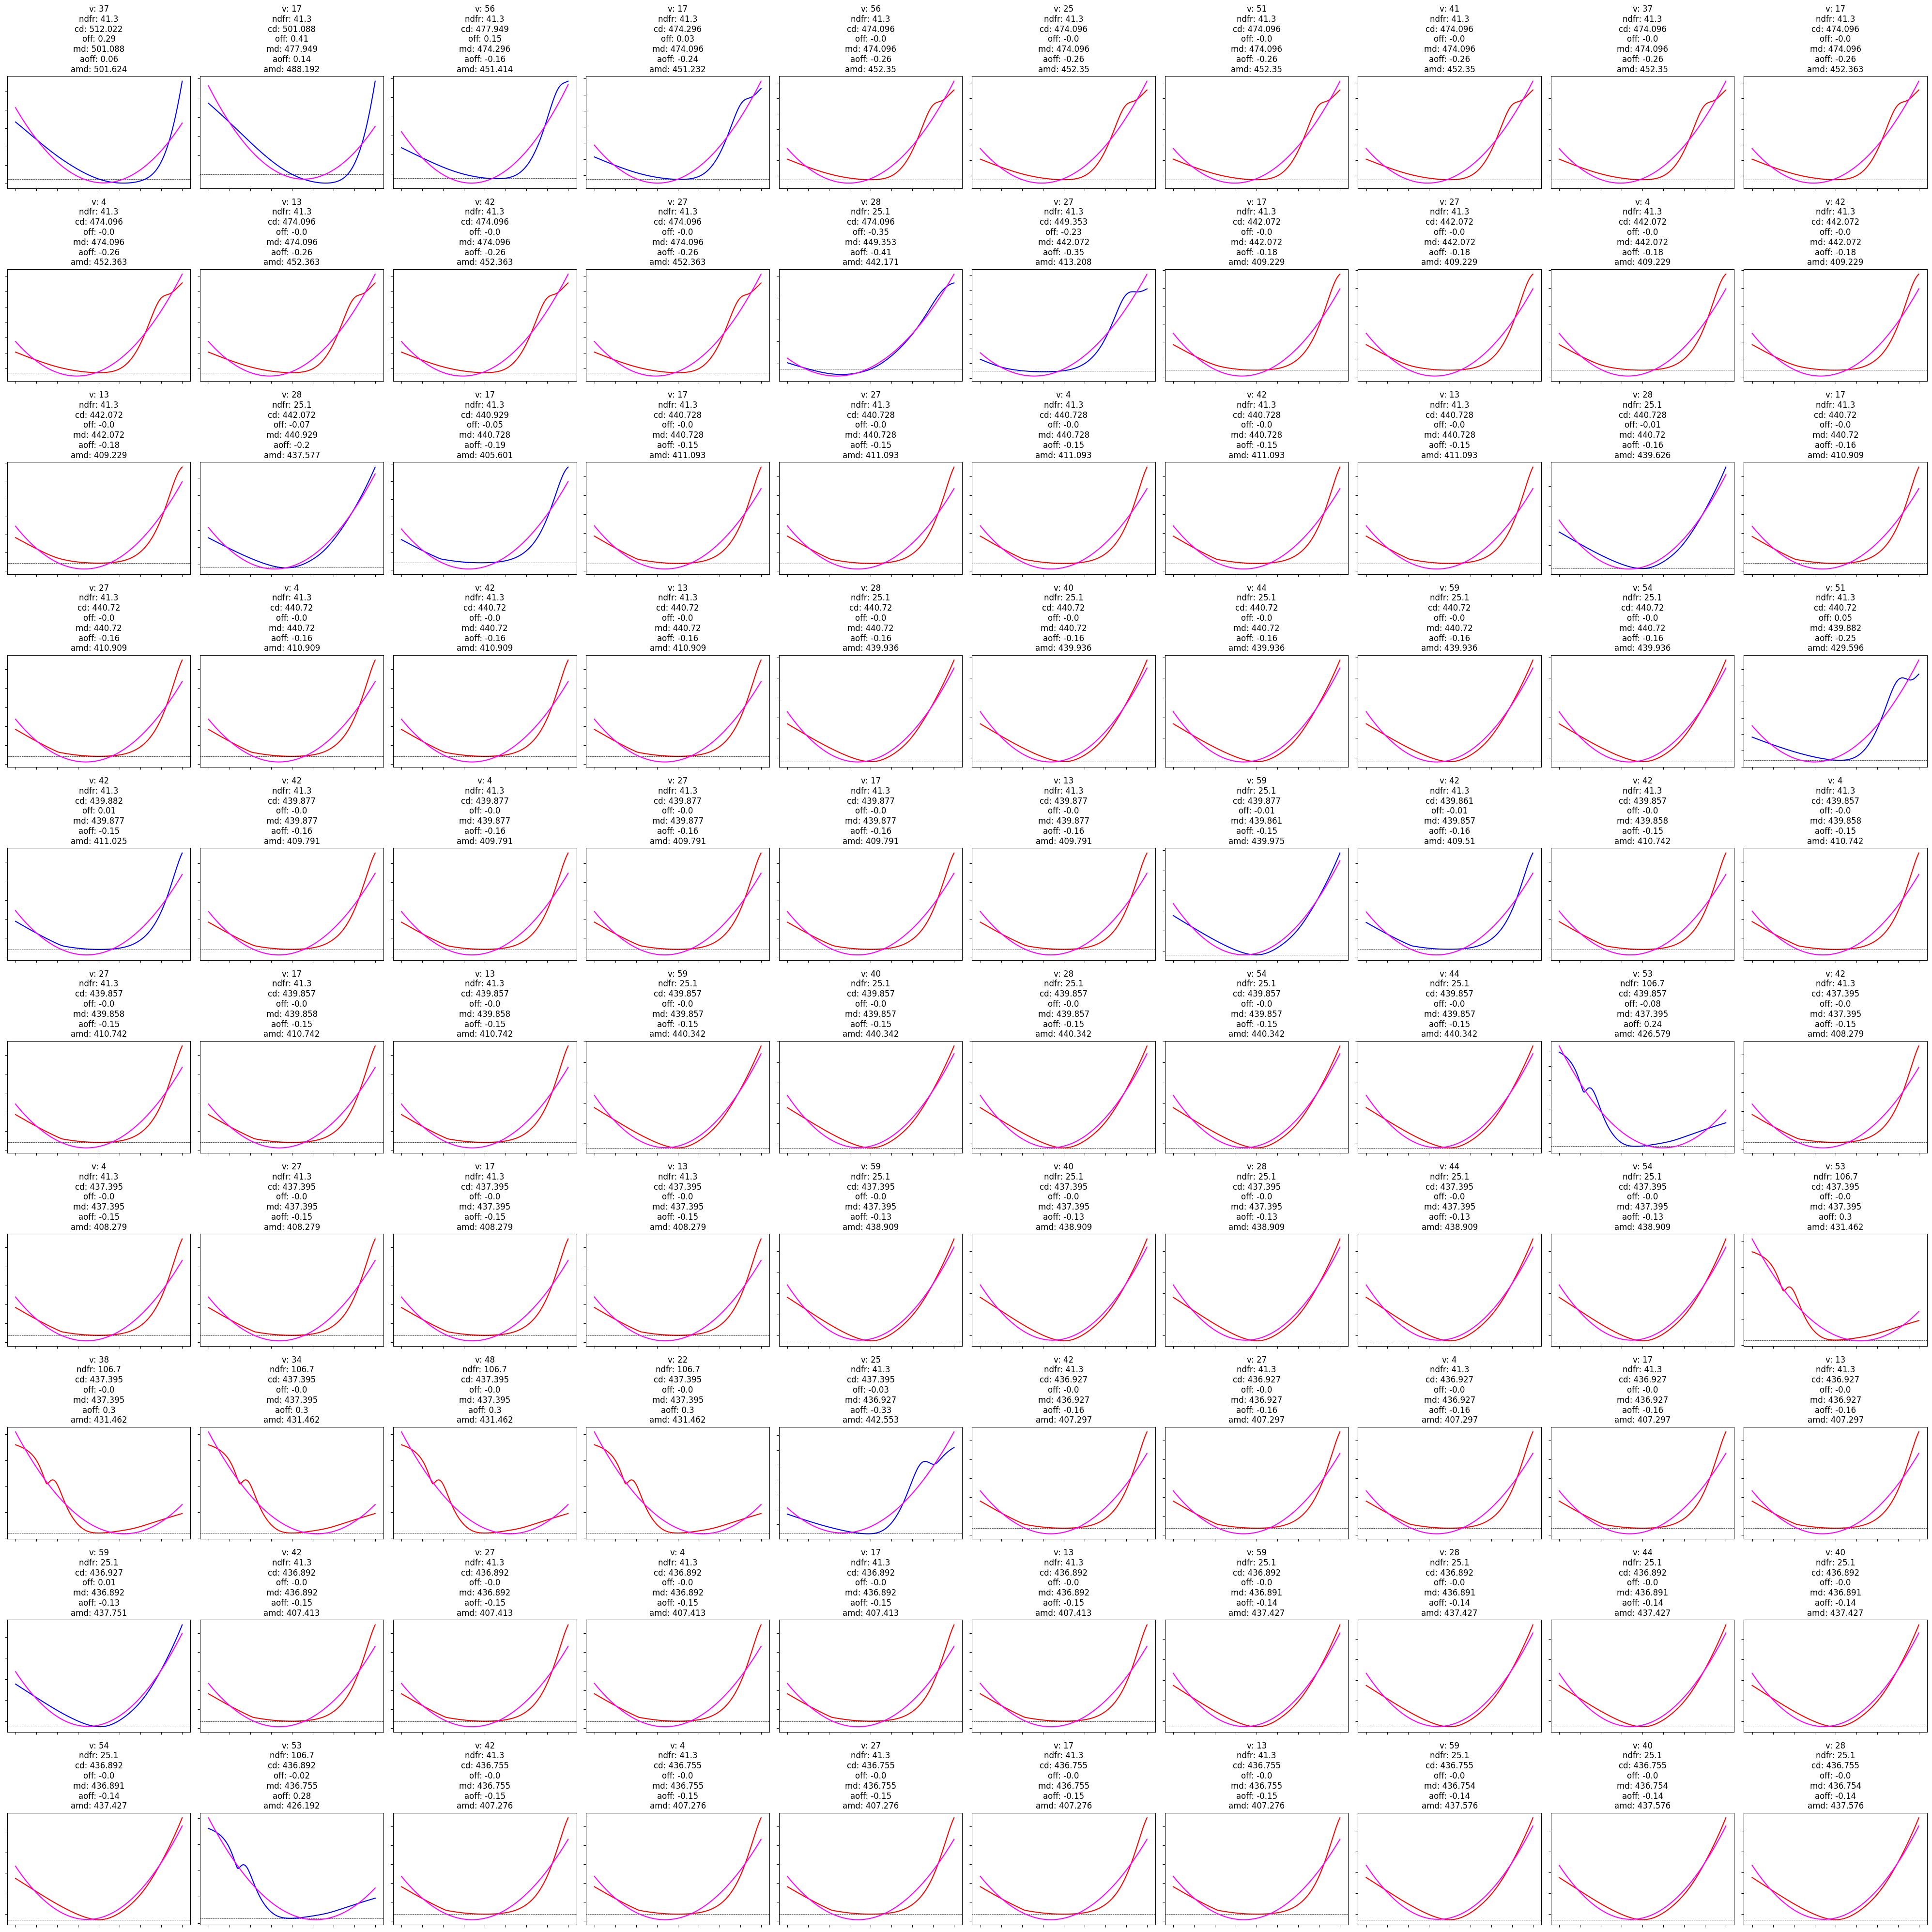

In [16]:
graph_json_iterative("Icosahedron_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


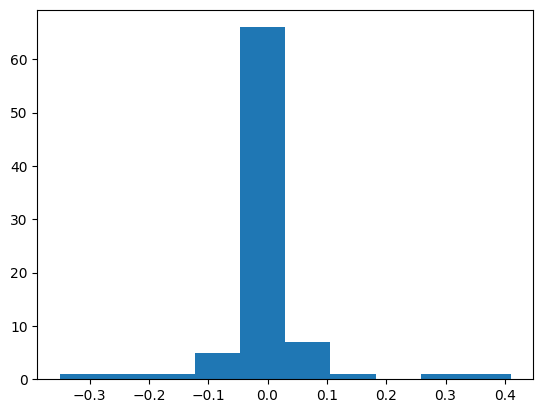

In [17]:
graph_offset_histogram_iterative("Icosahedron_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

Plot of total angular deviation (0; 9820.72) per offset (-1.0; 1.0), sampled every 0.009999999776482582
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: MirrorOptimizer method: Iterative
Vertex selection method: Maximum local angular deviation, skipping if no decrease in total deviation
First 100/1000 iterations plotted ltr-ttb
161 iterations of total amount (16.1%) reduced the minimum
Time: 333333 ms
Total angular deviation reduced from 9666.56 to 8174.29 (-15.44%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decrease

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/2222505165.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


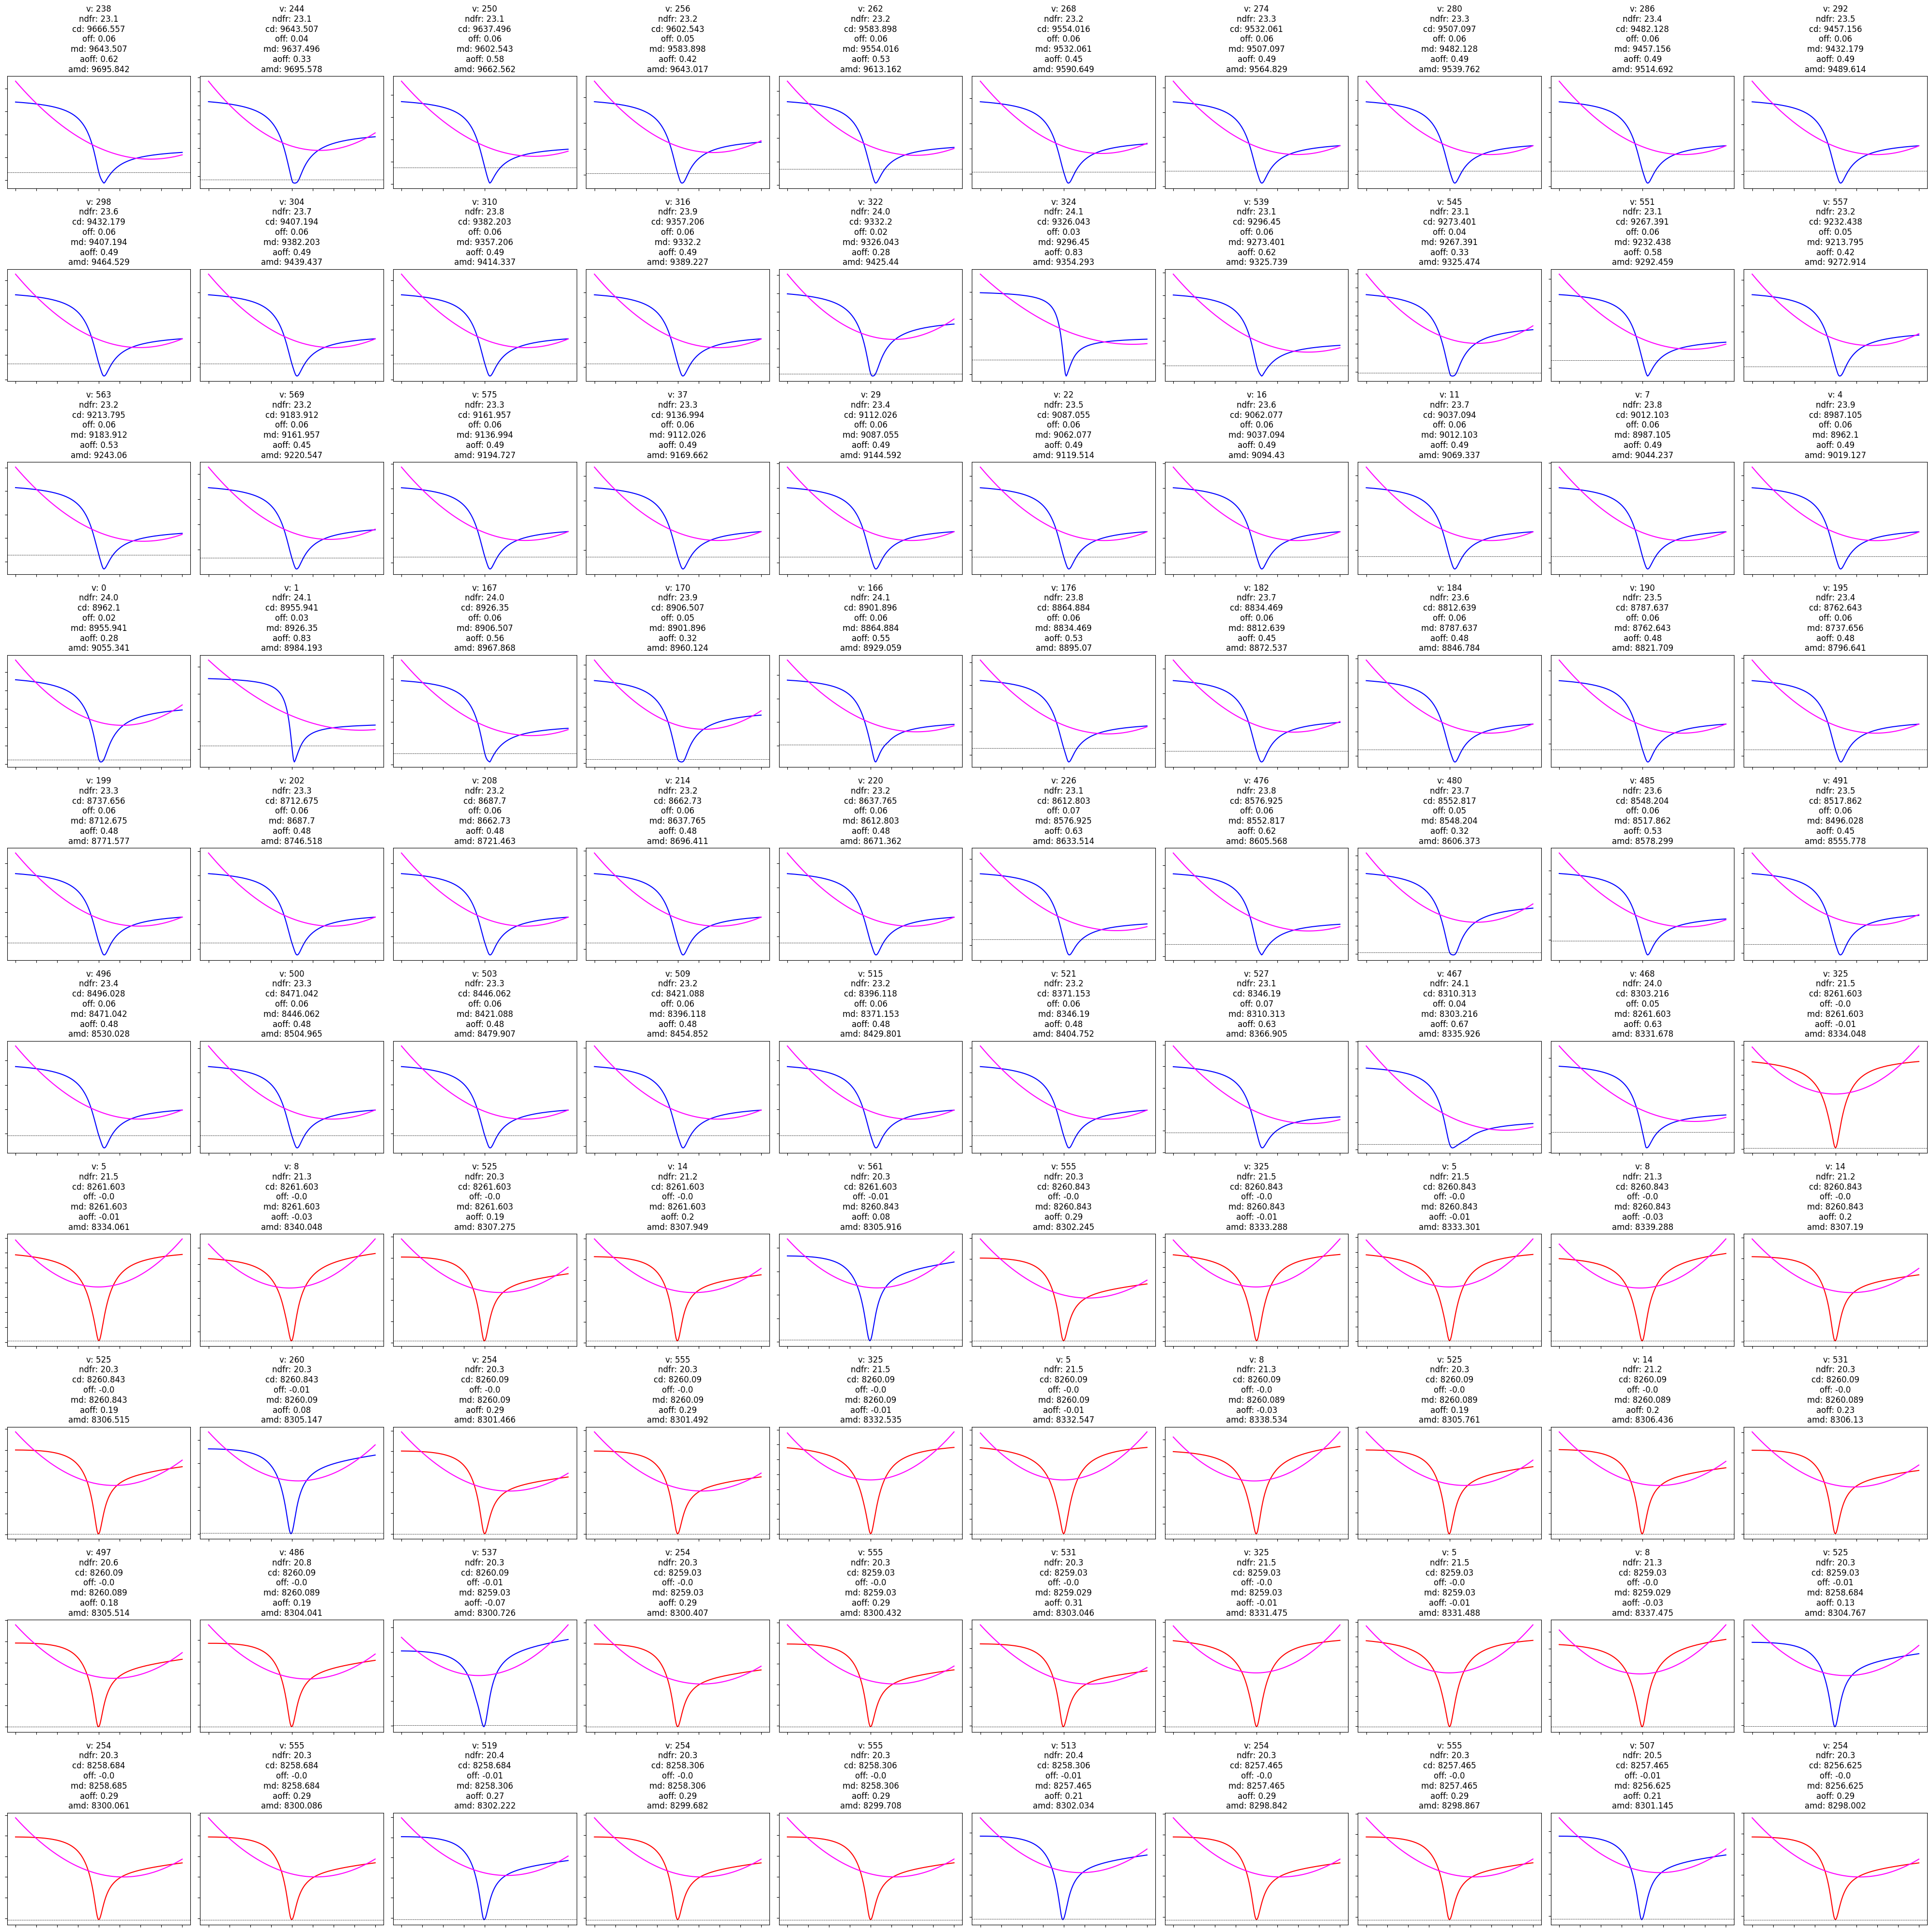

In [18]:
graph_json_iterative("High_Vertex_Plane_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/1267171723.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


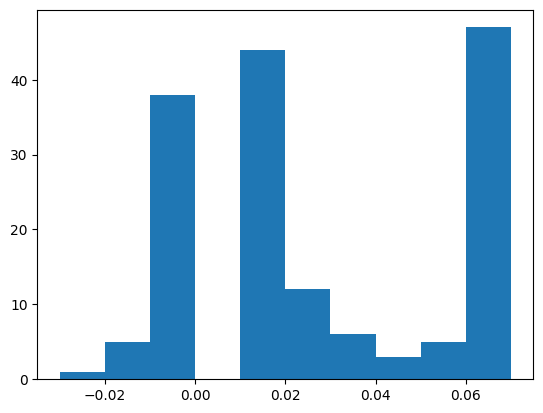

In [19]:
graph_offset_histogram_iterative("High_Vertex_Plane_Mirror_1000-Iterative_at_0.010_in_-1.00_to_1.00.json")

Plot of total angular deviation for 1000 iterations
Object: Tetrahedron
Vertices: 12 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
191 iterations of total amount (19.1%) reduced the minimum
Time: 10587 ms
Total angular deviation reduced from 229.31 to 120.19 (-46.6%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


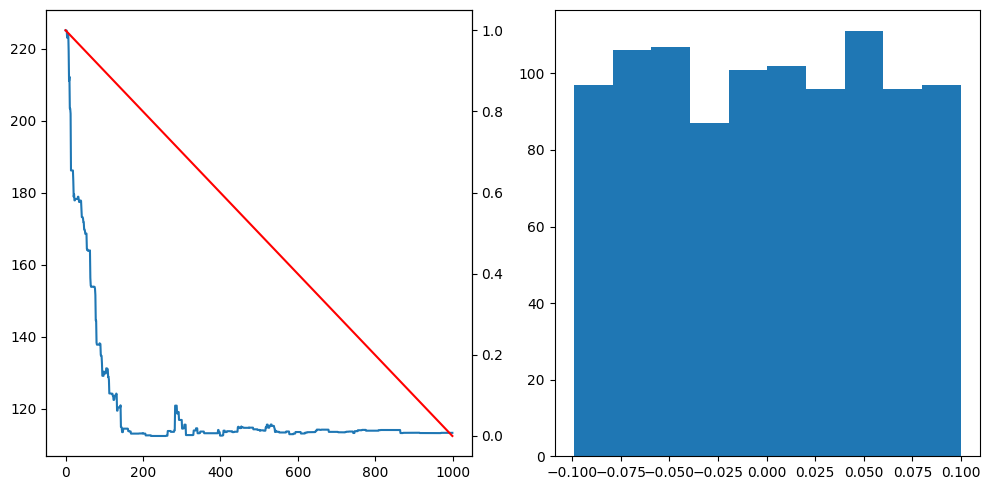

In [20]:
graph_json_annealing("Tetrahedron_Mirror_1000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 10000 iterations
Object: Tetrahedron
Vertices: 12 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
1662 iterations of total amount (16.62%) reduced the minimum
Time: 111029 ms
Total angular deviation reduced from 229.31 to 107.43 (-52.27%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


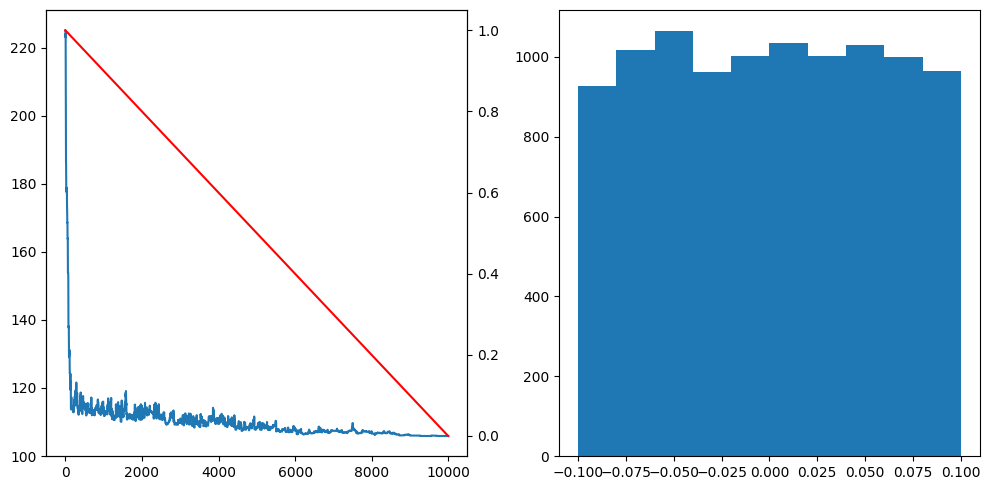

In [21]:
graph_json_annealing("Tetrahedron_Mirror_10000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 1000 iterations
Object: Cube
Vertices: 24 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
342 iterations of total amount (34.2%) reduced the minimum
Time: 10473 ms
Total angular deviation reduced from 107.27 to 18.62 (-82.55%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


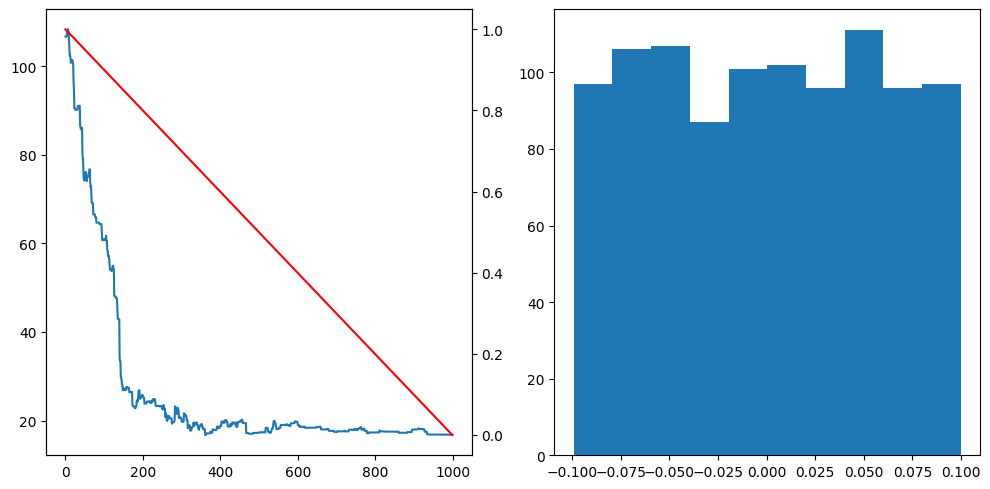

In [22]:
graph_json_annealing("Cube_Mirror_1000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 1000 iterations
Object: Icosahedron
Vertices: 60 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
374 iterations of total amount (37.4%) reduced the minimum
Time: 8880 ms
Total angular deviation reduced from 512.02 to 323.44 (-37.2%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


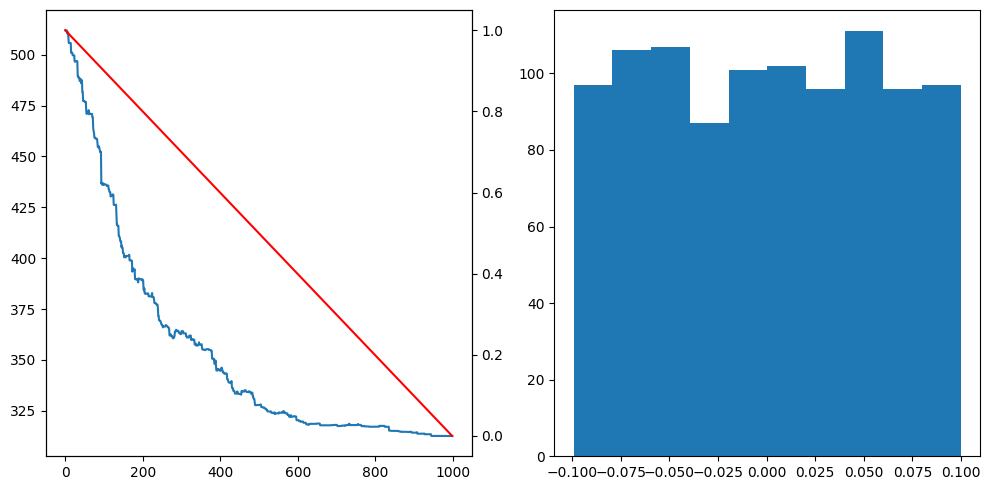

In [23]:
graph_json_annealing("Icosahedron_Mirror_1000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 10000 iterations
Object: Icosahedron
Vertices: 60 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
2351 iterations of total amount (23.51%) reduced the minimum
Time: 118498 ms
Total angular deviation reduced from 512.02 to 304.82 (-40.82%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


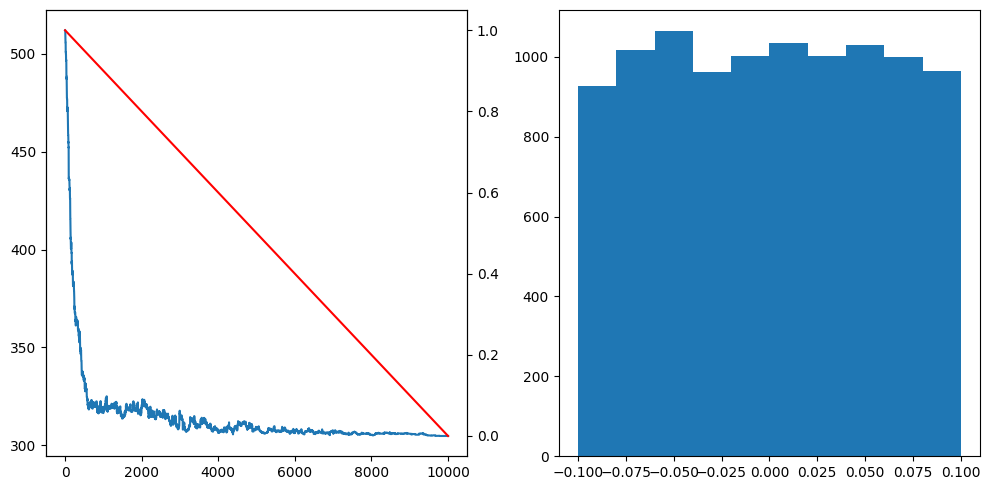

In [24]:
graph_json_annealing("Icosahedron_Mirror_10000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 10000 iterations
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
796 iterations of total amount (7.96%) reduced the minimum
Time: 150586 ms
Total angular deviation reduced from 9666.56 to 8179.11 (-15.44%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


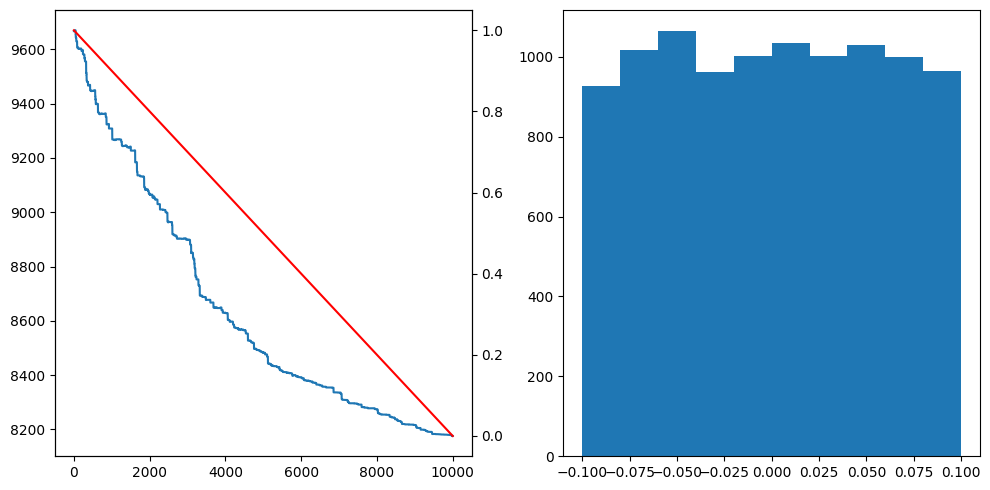

In [25]:
graph_json_annealing("High_Vertex_Plane_Mirror_10000-Annealing_in_-0.10_to_0.10.json")

Plot of total angular deviation for 100000 iterations
Object: High Vertex Plane
Vertices: 961 (if more vertices then expected, that is because of UV mapping. Vertices that only differ in UV coordinates are still treated at the same time)
Deformation method: Mirror
Optimizer method: Annealing
Vertex selection method: Random
 (seed 0)
5903 iterations of total amount (5.9%) reduced the minimum
Time: 1520646 ms
Total angular deviation reduced from 9666.56 to 6767.47 (-30.03%)

LEGEND
-------------
v: Current iteration's vertex
ndfr: ideal normal's degrees from ray -- used to see orthogonality of current iteration's vertex normal relative to viewpoint
cd: Current deviation
md: Minimum deviation of iteration
off: offset that corresponds to the (discrete) minimum

blue/red: plot of total angular deviation at each offset, if the iteration decreased the minimum (blue) or not (red)
pink: quadratic approximation of the original data
black dashed: current total angular deviation



/var/folders/ht/fjyngybj4s19bb50tv72p70h0000gn/T/ipykernel_11931/701351728.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


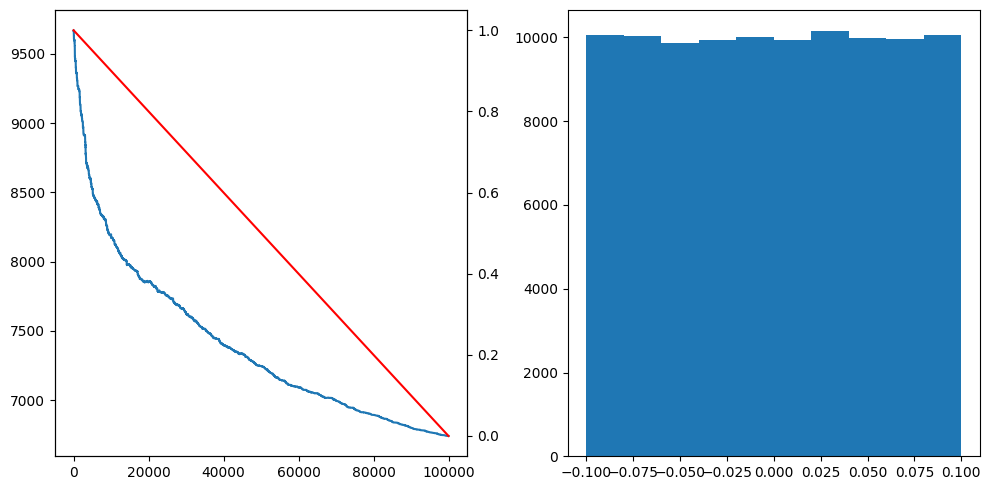

In [26]:
graph_json_annealing("High_Vertex_Plane_Mirror_100000-Annealing_in_-0.10_to_0.10.json")